In [1]:
!pip install torch-summary

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Created wheel for torch-summary: filename=torch_summary-1.1.8-cp27-none-any.whl size=11636 sha256=3790eb72f133ee5537f297a940e9f2b1a5e6f5221fa04613d7cabe04841e5abe
  Stored in directory: /Users/vico/Library/Caches/pip/wheels/d0/00/fe/bc8ad76c932d867937234e49895fd31cb8d7a6023330a967ee
Successfully built torch-summary


In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import os
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

In [2]:
train_dir = 'dataset/training_set/training_set'
test_dir = 'dataset/test_set/test_set'

In [3]:
cats_train = os.path.join(train_dir,'cats')
dogs_train = os.path.join(train_dir,'dogs')
cats_test =  os.path.join(test_dir,'cats')
dogs_test =  os.path.join(test_dir,'dogs')

In [4]:
def visualize_image():
    available_image_folders = [cats_train,dogs_train,cats_test,dogs_test]
    plt.figure(figsize=(15,7))
    for i in range(6):
        folder = random.choice(available_image_folders)
        plt.subplot(2,3,i+1)
        imgs_choice = random.choice([i for i in os.listdir(folder)])
        images_path = os.path.join(folder,imgs_choice)
        images = imread(images_path)
        plt.imshow(images)
    plt.show()

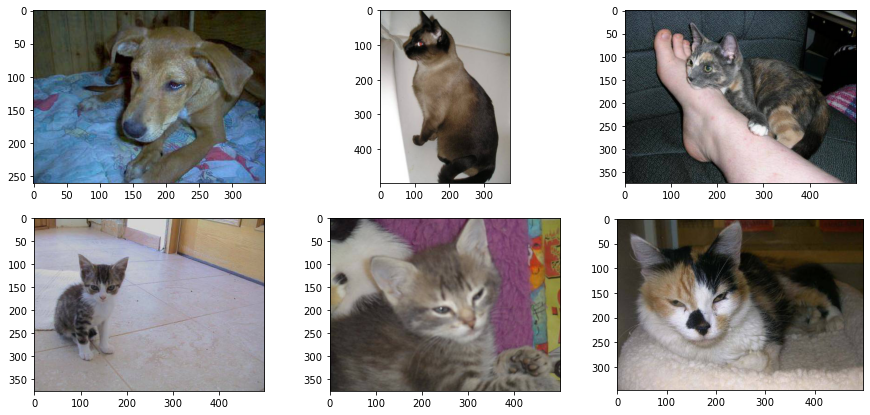

In [5]:
visualize_image()

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
])

test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
])

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset=torchvision.datasets.ImageFolder(train_dir,
                                                                                       transform=train_transform),
                                              shuffle=True,batch_size=32,num_workers=0)

In [8]:
test_dataloader = torch.utils.data.DataLoader(dataset=torchvision.datasets.ImageFolder(test_dir,
                                                                                     transform=test_transform),
                                             shuffle=True,batch_size=32,num_workers=0)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
model = torchvision.models.resnet50(pretrained=True).to(device)

In [11]:
# for params in model.parameters():
#     params.requires_grads = False
# model.fc = nn.Sequential(
#     nn.Linear(2048,128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128,2)
# ).to(device)

In [12]:
for params in model.parameters():
    params.requires_grads = False
model.fc = nn.Sequential(
    nn.Linear(2048,2),
).to(device)

In [13]:
criterian = nn.CrossEntropyLoss()
optimizers = torch.optim.Adam(model.fc.parameters())

In [14]:
model_summary = summary(model,(3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [16]:
n_epochs = 4
for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    for batch_idx,(data,labels) in tqdm_notebook(enumerate(train_dataloader)):
        data = data.to(device)
        labels = labels.to(device)
        optimizers.zero_grad()
        output = model(data)
        loss = criterian(output,labels)
        loss.backward()
        optimizers.step()
    print(f'epochs: {epoch} loss: {loss.item()}')

KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(),'./models/resnet50.h5')

In [18]:
test_imgs = ["dataset//cat.4001.jpg",
                        "/cats/cat.4003.jpg",
                        "/dogs/dog.4004.jpg",
                       "/dogs/dog.4006.jpg"]
img_list = [Image.open(test_dir + img_path) for img_path in test_imgs]

In [19]:
test_batch = torch.stack([test_transform(img).to(device)
                                for img in img_list])

In [20]:
pred_logits_tensor = model(test_batch)
pred_logits_tensor

tensor([[ 2.6176, -3.1433],
        [ 4.1405, -4.7976],
        [-3.2459,  4.4654],
        [-3.5575,  4.3446]], device='cuda:0', grad_fn=<AddmmBackward>)

In [21]:
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9686170e-01, 3.1382663e-03],
       [9.9986875e-01, 1.3126641e-04],
       [4.4751883e-04, 9.9955243e-01],
       [3.6982683e-04, 9.9963021e-01]], dtype=float32)

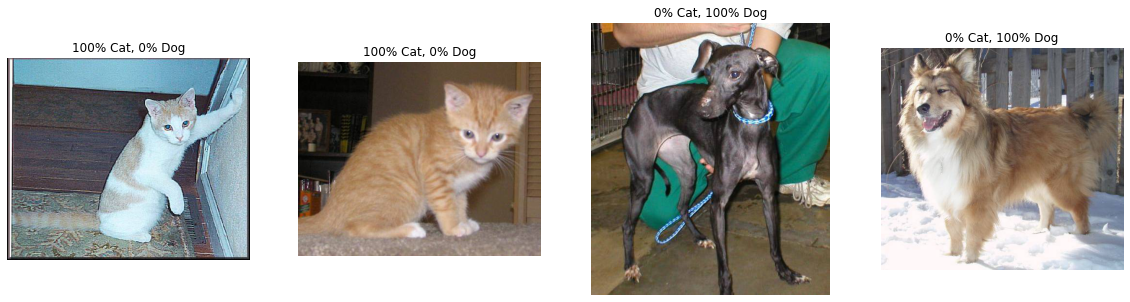

In [22]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)